In [1]:
% Toolbox Setup
cd ../
startup

loading optim
loading image
loading io
loading statistics
loading signal


# Hyperpolarized Metrics Evaluation

The goal of this notebook is to demonstrate simulation tools for comparing metrics of hyperpolarized MR metabolic data.  It is based on simulations originally presented in the following citation(s)

* Larson, Peder E. Z., Hsin-Yu Chen, Jeremy W. Gordon, Natalie Korn, John Maidens, Murat Arcak, Shuyu Tang, et al. “Investigation of Analysis Methods for Hyperpolarized 13C-Pyruvate Metabolic MRI in Prostate Cancer Patients.” NMR in Biomedicine 31, no. 11 (November 2018): e3997. https://doi.org/10.1002/nbm.3997.

It is very challenging to evaluate the accuracy of HP metabolism metrics in vivo because it is nearly impossible to have a ground truth values and the apparent rate constants can be influenced by a combination of perfusion/delivery, cellular uptake, intracellular transport (e.g. into mitochondria), enzymatic conversion, efflux out of cells, and out-flow, and compartmental T1 differences.

Given this limitation, simulations can be used very effectively to provide insight into evaluation of HP metabolism metrics.  Simulation parameters to evaluate should include key HP experimental variables such the conversion rates, relaxation rates, noise level, acquisition strategy (flip angles, timing), bolus and perfusion characteristics, and flip angle accuracy. 

Monte Carlo simulations, in which a signal is analyzed many times in the presence of unique added noise, can be used to characterize the response of metrics, both in terms of accuracy and precision.

## Simulated Data

This demonstration uses a precursor-product model of HP 13C-pyruvate to 13C-lactate conversion in a single physical compartment following a bolus injection.
However, this approach can be modified for other models as well, similar to the use of a two physical compartment model used in Sun, Chang-yu, Christopher M. Walker, Keith A. Michel, Aradhana M. Venkatesan, Stephen Y. Lai, and James A. Bankson. “Influence of Parameter Accuracy on Pharmacokinetic Analysis of Hyperpolarized Pyruvate.” Magnetic Resonance in Medicine 79, no. 6 (June 2018): 3239–48. https://doi.org/10.1002/mrm.26992.

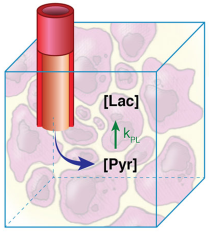
**Figure**: Precursor-product model for HP pyruvate in a single physical compartment.  All observed signal is assumed to be in contact with enzymes that mediate exchange.  The blue cube represents an imaging voxel.  Adapted from Bankson et al, Cancer Research 2015. https://doi.org/10.1158/0008-5472.CAN-15-0171

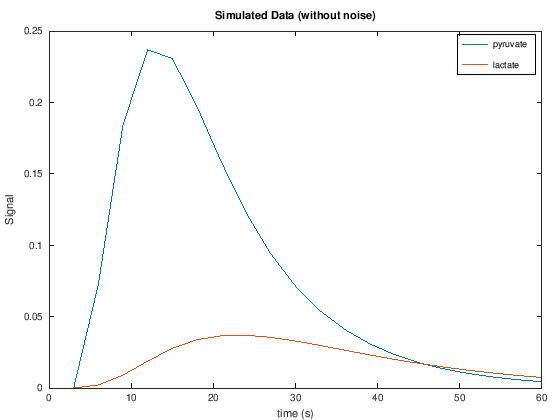

In [2]:
% sample data for the model

acq_sample.TR = 3;
acq_sample.N = 20;
acq_sample.flips = repmat([25*pi/180; 25*pi/180], [1 acq_sample.N]);
experiment_sample.R1P = 1/25; experiment_sample.R1L = 1/25; 
experiment_sample.kPL = 0.02;
experiment_sample.Tarrival = 0;  experiment_sample.Tbolus = 8;
    
[input_function, t_input] = realistic_input_function(acq_sample.N, acq_sample.TR, experiment_sample.Tarrival, experiment_sample.Tbolus);  % gives a full-width half-max of the bolus of ~ Tbolus sec

[Mxy Mz] = simulate_Nsite_model([0 0], [experiment_sample.R1P experiment_sample.R1L], [experiment_sample.kPL 0], acq_sample.flips, acq_sample.TR, input_function);

plot(t_input, Mxy)
xlabel('time (s)'), ylabel('Signal')
legend('pyruvate', 'lactate')
title('Simulated Data (without noise)')

## Monte Carlo Simulations

A Monte Carlo simulation is performed with a repeated set of random measurements.  For this application, it means adding different random noise to the simulated signal prior to determining a HP metabolism metric.

The `hyperpolarized-mri-toolbox` provides a helper function to perform these simulations

    [ results, hdata, hsim ] = HP_montecarlo_evaluation( acq, fitting, experiment );

    INPUTS:
    acq - structure containing acquisition parameters, must include TR, flips, N (number of timepoints)
    fitting - structure containing fitting parameters, including fit_fcn, params_est, params_fixed
       (for use with fit_pyr_kinetics* functions)    
    experiment - structure containing experimental parameters and ranges for simulations (optional)

    OUTPUTS:
    results - structure containing summary of results
    hdata, hsim - handles to figures from function

This creates plots of sample data, $k_{PL}$ versus the metric value, and the relative error of the metric as a function of variations in experimental parameters.

In [3]:
% Setup parameters

clear experiment acq

% default experiment values
experiment.R1P = 1/25;  experiment.R1L =1/25;  experiment.kPL = 0.02; 
%experiment.std_noise = 0.02;  % for kPL vs AUC figure
experiment.std_noise = 0.005; % for relative error figure
experiment.Tarrival = 0;  experiment.Tbolus = 8;

% Acquisition parameters
Tacq = 48;
acq.TR = 3; acq.N = Tacq/acq.TR;

In [4]:
clear params_est params_fixed

% default fitting parameters
R1P_est = 1/25; R1L_est = 1/25; kPL_est = .02;
Tarrival_est = experiment.Tarrival;    Tbolus_est = experiment.Tbolus;  % ... perfect estimates ... how do they perform with variability?
Rinj_est = 0.1; % looks reasonable

params_fixed.R1P = R1P_est;
params_fixed.R1L = R1L_est;
params_est.kPL = kPL_est;

In [5]:
% these structures choose the fitting methods to test
clear fitting

fitting(1).fit_fcn = @fit_pyr_kinetics;
fitting(1).params_fixed = params_fixed;
fitting(1).params_est = params_est;
fitting(1).fit_description = ['Inputless fitting'];
fitting(1).metric = 'kPL';

% fitting(2).fit_fcn = @fit_pyr_kinetics_and_input;
% params_est.Tarrival = Tarrival_est+2; params_est.Rinj = Rinj_est*1.2; params_est.Tbolus = Tbolus_est-1;
% params_est.Tarrival_lb = 0; params_est.Tarrival_ub = 12; params_est.Tbolus_lb = 6; params_est.Tbolus_ub = 10;
% fitting(2).params_fixed = params_fixed;
% fitting(2).params_est = params_est;
% fitting(2).fit_description = ['Fitting the input function'];
% fitting(2).metric = 'kPL';

fitting(2).fit_fcn = @fit_pyr_kinetics;
clear params_est params_fixed 
params_fixed.R1P = R1P_est;
params_est.R1L = R1L_est;
params_est.kPL = kPL_est;
fitting(2).params_fixed = params_fixed;
fitting(2).params_est = params_est;
fitting(2).fit_description = ['Inputless Fitting with T1 Fit'];
fitting(2).metric = 'kPL';

fitting(3).fit_fcn = @compute_AUCratio;
fitting(3).metric = 'AUCratio';  %
fitting(3).fit_description = ['AUC Ratio'];

% Ifitting = 4;
% fitting(Ifitting).fit_fcn = @compute_mean_time;
% fitting(Ifitting).metric = 'LactateMeanTime';  %
% fitting(Ifitting).fit_description = ['Lactate Mean Time'];
% 
% Ifitting = 5;
% fitting(Ifitting).fit_fcn = @compute_TTP;
% fitting(Ifitting).metric = 'LactateTTP';  %
% fitting(Ifitting).fit_description = ['Lactate Time-to-Peak'];

flip angle scheme: metabolite-specific 20(pyruvate)/30(lactate)-degrees


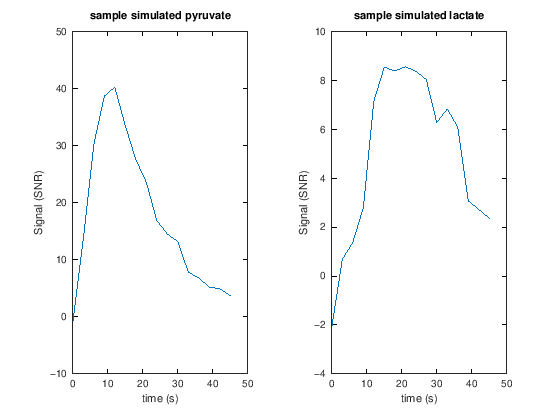

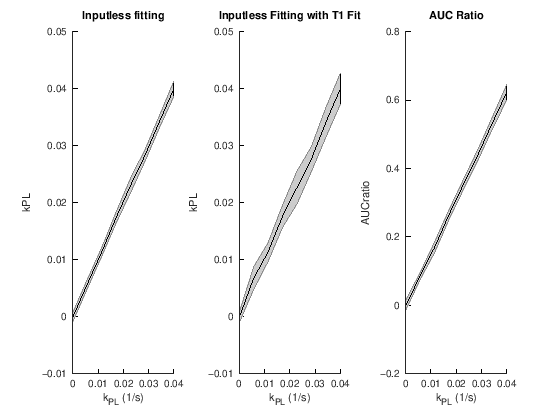

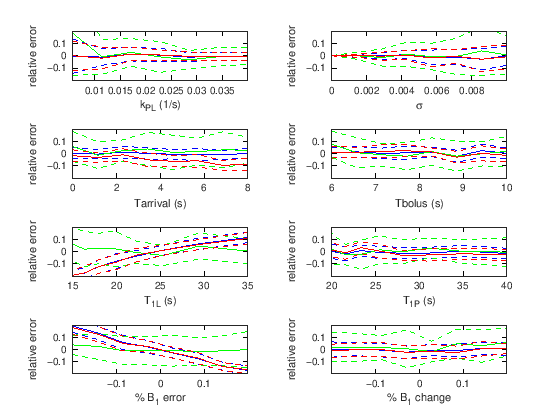

In [6]:
%Run the simulation

% number of repetitions of simulation for Monte Carlo evaluation
experiment.NMC = 25;  % using fewer in this example for quicker testing, increase to several hundred for more robust results

% Options to choose from three different flip angle schemes
flip_scheme = 2;
switch flip_scheme
    case 1
        acq.flips = repmat([25*pi/180; 25*pi/180], [1 acq.N]);
        flip_description = 'constant 25-degrees';
    case 2
        acq.flips = repmat([20*pi/180; 30*pi/180], [1 acq.N]);
        flip_description = 'metabolite-specific 20(pyruvate)/30(lactate)-degrees';
    case 3
        k12 = 0.05; % for variable flip angle designs
        acq.flips = [vfa_const_amp(acq.N, pi/2, exp(-acq.TR * ( k12))); ... % T1-effective pyruvate variable flip angles
            vfa_opt_signal(acq.N, exp(-acq.TR * ( R1L_est)))]; % max lactate SNR variable flip angle
        flip_description = 'metabolite-specific variable flip angle';
end

disp(['flip angle scheme: ' flip_description])

[results, hdata, hsim ] = HP_montecarlo_evaluation( acq, fitting, experiment );


In the above plots
* blue is the metric defined by `fitting(1)` (nominally "Inputless fitting")
* green is the metric defined by `fitting(2)` (nominally "Inputless fitting with T1 Fit")
* red is the metric defined by `fitting(3)` (nominally "AUC ratio")

(Manipulating the `legend` location in Octave was challenging!)